In [1]:
!date

Mon Nov  9 11:35:17 PST 2020


# Merfish 10x comparison

In [181]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [182]:
unique_map = {'Astrocytes': "Astro",
'Endothelial':"Endo",
'SMC':"SMC",
'L23_IT':"L2/3 IT",
'VLMC': "VLMC",
'L6_CT': "L6 CT",
'L45_IT': "L4/5 IT",
'L5_PT': "L5 PT",
'L5_IT': "L5 IT",
'Sst': "Sst",
'L6_IT': "L6 IT",
'Sncg': "Sncg",
'L6_IT_Car3': "L6 IT Car3",
'Vip': "Vip",
'L56_NP': "L5/6 NP",
'Pvalb': "Pvalb",  
'L6b': "L6b",
'Lamp5': "Lamp5"}

inv_map = {v: k for k, v in unique_map.items()}

In [183]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [184]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [185]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [186]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [187]:
mfish = anndata.read_h5ad("../../data/notebook/revision/merfish-updated.h5ad")

mfish.obs["tenx_subclass"] = mfish.obs["subclass"].apply(lambda x: unique_map.get(x, "None"))
mfish = mfish[mfish.obs.tenx_subclass != "None"]

In [188]:
md = pd.read_csv("../../reference/10xv3_cluster_labels/sample_metadata.csv", index_col = 0)

md["sex"] = md["Gender"].apply(lambda x: {"Male": "M", "Female":"F"}.get(x, "X"))

tenx = anndata.read_h5ad("../../data/notebook/revision/10xv3_gene.h5ad")
tenx.obs["date"] = tenx.obs.index.map(md["Amp_Date"])
tenx.obs["sex"] =  tenx.obs.index.map(md["sex"])

tenx = tenx[:,tenx.var.gene_short_name.isin(mfish.var.index)]

tenx.var.index = tenx.var.gene_short_name.values
#tenx = tenx[tenx.obs.eval("date == '11/29/2018'").values] # males
#tenx = tenx[tenx.obs.eval("date == '12/7/2018'").values] # females
tenx = tenx[tenx.obs.eval("date == '4/26/2019'").values] # females and males
#tenx = tenx[tenx.obs.subclass_label!="Low Quality"]



In [189]:
md.groupby("Amp_Date")["sex"].value_counts()

Amp_Date    sex
11/29/2018  M      60381
12/7/2018   F      54779
4/26/2019   F      35020
            M      26404
Name: sex, dtype: int64

In [190]:
print(tenx)
print(mfish)

View of AnnData object with n_obs × n_vars = 35370 × 254
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'date', 'sex'
    var: 'gene_name', 'gene_id', 'gene_short_name'
View of AnnData object with n_obs × n_vars = 228355 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'tenx_subclass'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'


In [191]:
tenx.obs.subclass_label.value_counts()

L5 IT          10084
Low Quality     8500
L6 CT           5886
L2/3 IT         3722
L6 IT           1841
L5/6 NP         1136
Vip             1020
Sst              871
Lamp5            699
Pvalb            359
Oligo            253
Sncg             196
L6b              169
doublet          156
Astro            148
Endo              78
OPC               71
Macrophage        69
L5 PT             49
L6 IT Car3        39
VLMC              21
SMC                3
Name: subclass_label, dtype: int64

In [192]:
mfish.obs.subclass.value_counts()

L23_IT         41996
L45_IT         34901
L6_CT          26278
Astrocytes     22879
Endothelial    20335
L5_IT          19585
L6_IT          15598
L5_PT           8320
Pvalb           7682
VLMC            6923
SMC             4246
Sst             3954
L56_NP          3896
L6b             3500
Lamp5           3156
Vip             2931
L6_IT_Car3      1827
Sncg             348
Name: subclass, dtype: int64

# Process

In [193]:
from sklearn.preprocessing import normalize

In [194]:
tenx.layers["X"] = tenx.X
tenx.layers["norm"] = normalize(tenx.X, norm='l1', axis=1)*1000000
tenx.layers["log1p"] = csr_matrix(np.log1p(tenx.layers["norm"]))

In [195]:
from sklearn.preprocessing import scale

In [196]:
%%time
mat = tenx.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
tenx.X = mtx

CPU times: user 272 ms, sys: 110 ms, total: 382 ms
Wall time: 381 ms


In [197]:
del mat

# Cluster comparisons

In [198]:
tenx = tenx[:,tenx.var.sort_index().index]
mfish = mfish[:,mfish.var.sort_index().index]

In [199]:
tenx.var.head()

,gene_name,gene_id,gene_short_name
1700022I11Rik_ENSMUSG00000028451,1700022I11Rik_ENSMUSG00000028451,ENSMUSG00000028451,1700022I11Rik
1810046K07Rik_ENSMUSG00000036027,1810046K07Rik_ENSMUSG00000036027,ENSMUSG00000036027,1810046K07Rik
5031425F14Rik_ENSMUSG00000085129,5031425F14Rik_ENSMUSG00000085129,ENSMUSG00000085129,5031425F14Rik
5730522E02Rik_ENSMUSG00000032985,5730522E02Rik_ENSMUSG00000032985,ENSMUSG00000032985,5730522E02Rik
Acta2_ENSMUSG00000035783,Acta2_ENSMUSG00000035783,ENSMUSG00000035783,Acta2


In [200]:
mfish.var.head()

,n_iso
1700022I11Rik,5
1810046K07Rik,2
5031425F14Rik,1
5730522E02Rik,8
Acta2,1


In [201]:
mfish_mat = mfish.X
mfish_ass = mfish.obs.tenx_subclass.values

tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

In [202]:
features = mfish.var.index.values

unique = np.intersect1d(np.unique(mfish_ass), np.unique(tenx_ass))

In [203]:
%%time
rvals = []
tenx_x = []
mfish_x = []

for uidx, u in enumerate(unique):
    mfish_t_mat, _ = split_by_target(mfish_mat, mfish_ass, u)
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    
    
    mf = np.asarray(mfish_t_mat.mean(axis=0)).reshape(-1)
    t = np.asarray(tenx_t_mat.mean(axis=0)).reshape(-1)
    
    tenx_x.append(t)
    mfish_x.append(mf)
    
    r, p = stats.pearsonr(mf, t)
    rvals.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 17] 0.79: Astro
[2 of 17] 0.76: Endo
[3 of 17] 0.84: L2/3 IT
[4 of 17] 0.44: L5 IT
[5 of 17] 0.78: L5 PT
[6 of 17] 0.89: L5/6 NP
[7 of 17] 0.90: L6 CT
[8 of 17] 0.85: L6 IT
[9 of 17] 0.83: L6 IT Car3
[10 of 17] 0.89: L6b
[11 of 17] 0.90: Lamp5
[12 of 17] 0.86: Pvalb
[13 of 17] 0.62: SMC
[14 of 17] 0.84: Sncg
[15 of 17] 0.90: Sst
[16 of 17] 0.32: VLMC
[17 of 17] 0.86: Vip
CPU times: user 1.76 s, sys: 1.95 s, total: 3.7 s
Wall time: 3.69 s


In [204]:
tenx_size = tenx.obs["subclass_label"].value_counts()[unique]

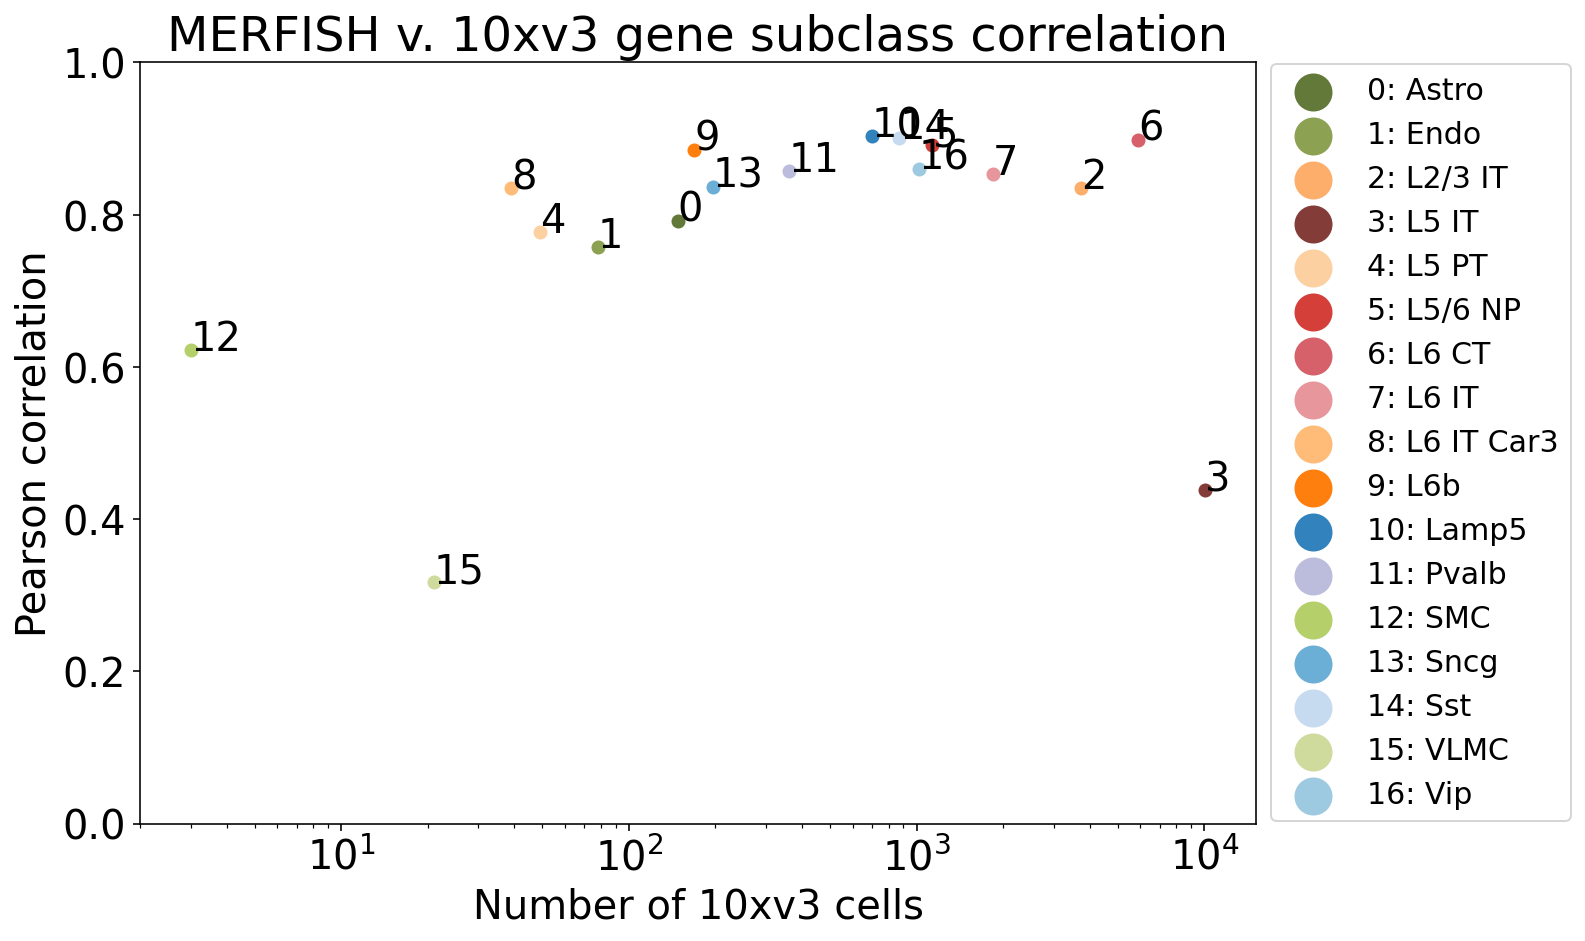

In [206]:
fig, ax = plt.subplots(figsize=(10,7))

x = tenx_size
y = rvals

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of 10xv3 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
ax.set_title("MERFISH v. 10xv3 gene subclass correlation")
plt.savefig(trackfig("../../figures/merfish-updated_10x_gene_subclass_size.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)
plt.show()

In [207]:
# males
males = pd.DataFrame({"subclass": unique.tolist(), 
              "rvals": rvals,
              "size": tenx.obs.subclass_label.value_counts()[unique]})

In [208]:
males

,subclass,rvals,size
Astro,Astro,0.792144,148
Endo,Endo,0.757713,78
L2/3 IT,L2/3 IT,0.835533,3722
L5 IT,L5 IT,0.437686,10084
L5 PT,L5 PT,0.776867,49
L5/6 NP,L5/6 NP,0.891412,1136
L6 CT,L6 CT,0.898038,5886
L6 IT,L6 IT,0.853549,1841
L6 IT Car3,L6 IT Car3,0.834760,39
L6b,L6b,0.885285,169


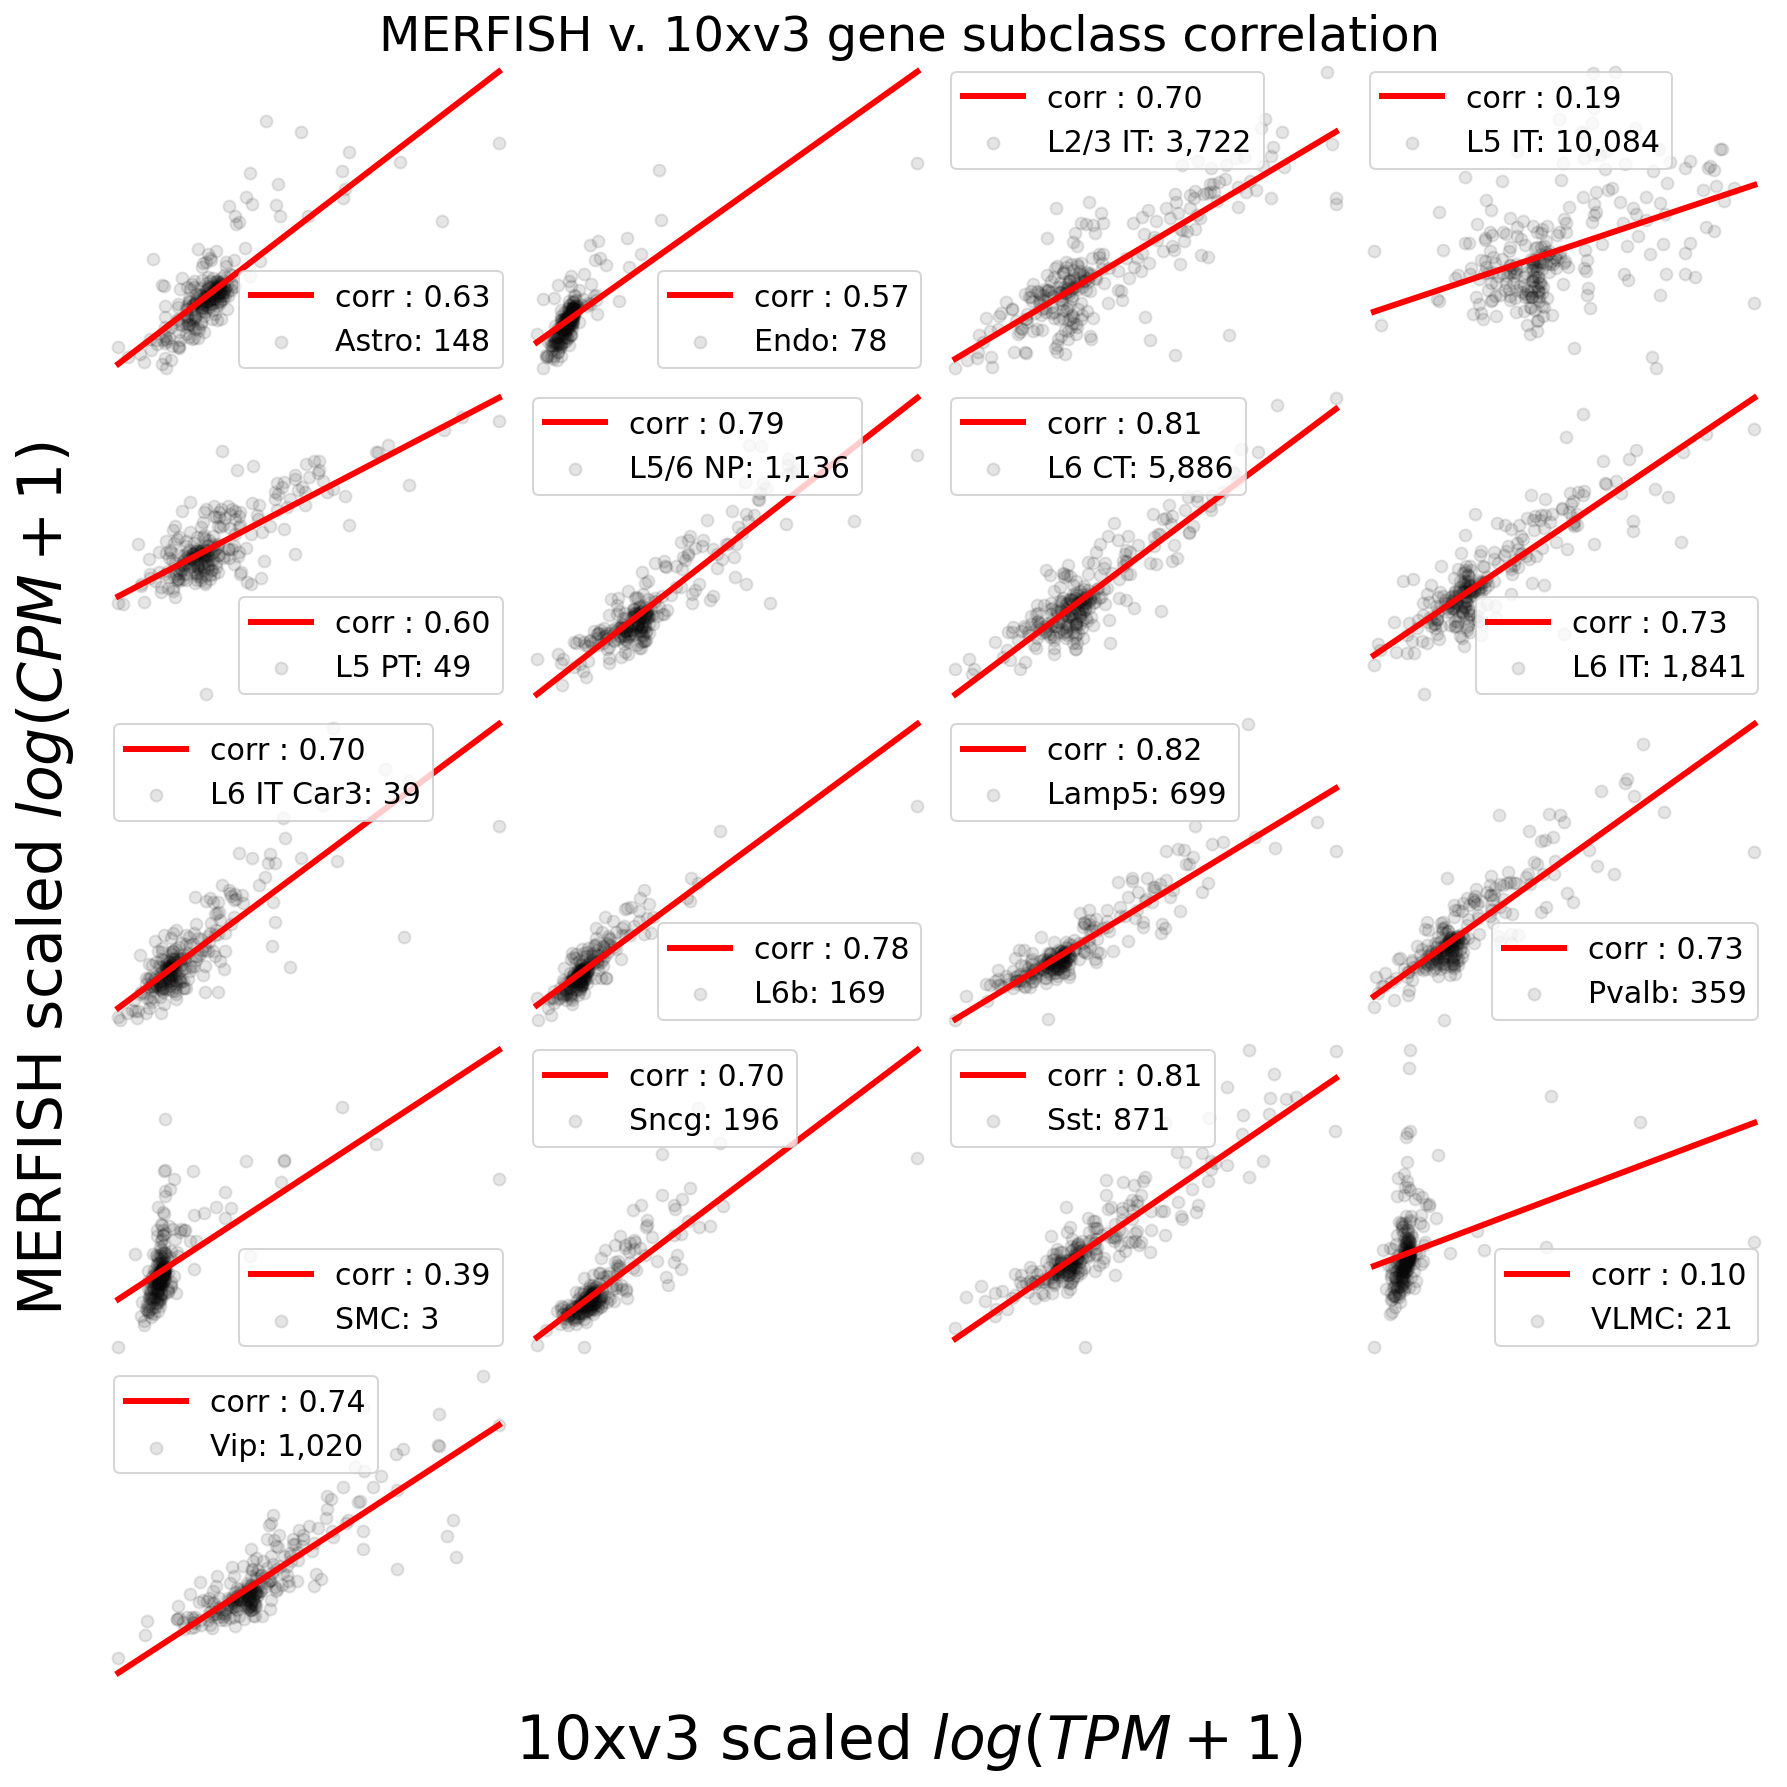

In [209]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))
fig.suptitle('MERFISH v. 10xv3 gene subclass correlation', y=0.9)
#fig.subplots_adjust(top=1)

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = tenx_x[cidx]
    y = mfish_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, tenx_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, '10xv3 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'MERFISH scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)

plt.savefig(trackfig("../../figures/merfish-updated_10x_gene_subclass_correlation_scatter.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()

In [210]:
tenx[tenx.obs.subclass_label=="L5 IT"].obs.cluster_label.value_counts()

L5 IT Tcap_2    5533
L5 IT Tcap_1    2730
L5 IT S100b     1605
L5 IT Pld5       216
Name: cluster_label, dtype: int64

In [211]:
mfish[mfish.obs.subclass=="L5_IT"].obs.label.value_counts()

L5_IT_1    7440
L5_IT_4    4666
L5_IT_2    4595
L5_IT_3    2884
Name: label, dtype: int64

In [212]:
rvals

[0.7921444158185055,
 0.7577133744111573,
 0.8355333876586635,
 0.4376861471951722,
 0.7768667940090835,
 0.8914118229015247,
 0.8980376879672993,
 0.8535492803061333,
 0.8347604493356554,
 0.885285096757754,
 0.9029529394527941,
 0.856814503483428,
 0.6224264131127573,
 0.8368220223374623,
 0.9011701921410472,
 0.3169404799062017,
 0.8606436651620778]

In [213]:
unique.tolist()

['Astro',
 'Endo',
 'L2/3 IT',
 'L5 IT',
 'L5 PT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'Lamp5',
 'Pvalb',
 'SMC',
 'Sncg',
 'Sst',
 'VLMC',
 'Vip']